# D7059E

*   Jacob Yousif
*   Donato Scarano


## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture
!pip install imbalanced-learn xgboost seaborn

In [3]:
!pip install optuna
!pip install --upgrade lightgbm

In [4]:
%%capture
import numpy as np
from IPython.display import display, Latex
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from itertools import cycle
from scipy.stats import randint, uniform
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer

from xgboost import XGBClassifier
import optuna
import optuna.visualization as vis

## Data Loading

In [5]:
file_path = 'datasets/Vectorized15SentenceSegments.csv'
df = pd.read_csv(file_path)
main = df.copy()

In [6]:
plots_dir = 'c/16/'

In [7]:
df = df.dropna().reset_index(drop=True)

In [8]:
print('The length of the dataset is:', str(len(df)))

The length of the dataset is: 28836


In [9]:
has_nan = df.isnull().values.any()
print(f"Are there any NaN values in the DataFrame? {has_nan}")

Are there any NaN values in the DataFrame? False


In [10]:
print(f"Does the DataFrame have any NaN values? {df.isna().sum().sum()}")

Does the DataFrame have any NaN values? 0


## Authors

In [11]:
authors = df.groupby('AuthorCode').agg(SegmentCount=('AuthorCode', 'size'), Author=('Author', 'first')).reset_index()

In [12]:
authors

,AuthorCode,SegmentCount,Author
0,0,1461,Jane Austen
1,1,576,L. Frank Baum
2,2,2014,Joseph Conrad
3,3,1928,Charles Dickens
4,4,2073,George Eliot
5,5,1624,Gustave Flaubert
6,6,1702,E. M. Forster
7,7,614,Kenneth Grahame
8,8,4854,Victor Hugo
9,9,1219,Jack London


### Pre-defined Setup

In [13]:
x_columns = [
    'AverageWordLength', 'AverageSentenceLengthByWord', 'AverageSyllablePerWord', 'SpecialCharactersCount',
    'PunctuationCount', 'FunctionalWordsCount', 'TypeTokenRatio', 'HonoreMeasureR',
    'Hapax', 'SichelesMeasureS', 'Dihapax', 'YulesCharacteristicK', 'SimpsonsIndex',
    'BrunetsMeasureW', 'ShannonEntropy', 'FleschReadingEase', 'FleschKincaidGradeLevel',
    'DaleChallReadability', 'GunningFog'
]
y_column = ['AuthorCode']

In [14]:
def write(file_name, latex_table):
    with open(file_name, 'w') as f:
        f.write(latex_table)

In [15]:
def to_pascal_case(s):
    return ''.join(word.capitalize() for word in s.split('_'))

In [16]:
latex_table = authors.to_latex()
write(f'{plots_dir}authorsXGBoost.txt', latex_table)

### LightGBM

In [17]:
X = df[x_columns].values

In [18]:
le = LabelEncoder()
y = le.fit_transform(df[y_column].values)

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.5),  # Increased range for stronger regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 0.5),  # Increased range for stronger regularization
    }

    try:
        clf = lgb.LGBMClassifier(**params, random_state=42)
        clf.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_logloss',
            early_stopping_rounds=3,  # Increased to allow more patience for early stopping
            callbacks=[lgb.log_evaluation(10)]
        )
        
        evals_result = clf.evals_result_
        val_logloss = evals_result['valid_0']['multi_logloss'][-1]

    except Exception as e:
        print(f"An error occurred in trial {trial.number}: {e}")
        return float('inf')

    return val_logloss

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300, timeout=3600, show_progress_bar=False) 

An error occurred in trial 0: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
An error occurred in trial 1: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
An error occurred in trial 2: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
An error occurred in trial 3: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
An error occurred in trial 4: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
An error occurred in trial 5: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
An error occurred in trial 6: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
An error occurred in trial 7: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
An error occurred in trial 8: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
An error o

In [23]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 300
Best trial: {'n_estimators': 140, 'max_depth': 7, 'num_leaves': 36, 'learning_rate': 0.04515518930054411, 'min_child_samples': 24, 'subsample': 0.6444593043305297, 'colsample_bytree': 0.676062229348927, 'reg_alpha': 0.0516158189332812, 'reg_lambda': 0.3139812471363447}


In [24]:
def create_results_dataframe(study):
    results = []
    for trial in study.trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            results.append({
                'Max Depth': trial.params.get('max_depth'),
                'N Estimators': trial.params.get('n_estimators'),
                'Learning Rate': trial.params.get('learning_rate'),
                'Mean Test Score': trial.value
            })
    return pd.DataFrame(results)

In [25]:
results_df = create_results_dataframe(study)

In [26]:
def plot_parameter_effects(data, parameter, plots_dir):
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=data, x=parameter, y='Mean Test Score', marker='s', label=parameter.capitalize())
    plt.xlabel(parameter.upper())
    plt.ylabel('Mean Test Score')
    plt.title(f'Effect Of {parameter.upper()} On Model Performance: LightGBM')
    plt.xticks(rotation=45) 
    plt.grid(False) 
    plt.ylim(0, 1)
    plt.savefig(f'{plots_dir}effect_of_{parameter}_LightGBM_16_new.pdf', bbox_inches='tight')
    plt.show()

In [27]:
best_params = study.best_params

In [28]:
best_lgb = lgb.LGBMClassifier(**best_params, random_state=42)
best_lgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[lgb.log_evaluation(100)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4777
[LightGBM] [Info] Number of data points in the train set: 20185, number of used features: 19
[LightGBM] [Info] Start training from score -2.982200
[LightGBM] [Info] Start training from score -3.913758
[LightGBM] [Info] Start training from score -2.661350
[LightGBM] [Info] Start training from score -2.704835
[LightGBM] [Info] Start training from score -2.632687
[LightGBM] [Info] Start training from score -2.876547
[LightGBM] [Info] Start training from score -2.830146
[LightGBM] [Info] Start training from score -3.848910
[LightGBM] [Info] Start training from score -1.781753
[LightGBM] [Info] Start training from score -3.163935
[LightGBM] [Info] Start training from score -3.137329
[LightGBM] [Info] Start training from score -3.247011
[LightGBM] [Info] Start training from score -2.977325
[LightGBM

LGBMClassifier(colsample_bytree=0.676062229348927,
               learning_rate=0.04515518930054411, max_depth=7,
               min_child_samples=24, n_estimators=140, num_leaves=36,
               random_state=42, reg_alpha=0.0516158189332812,
               reg_lambda=0.3139812471363447, subsample=0.6444593043305297)

In [29]:
evals_result = best_lgb.evals_result_

In [30]:
train_loss = evals_result['training']['multi_logloss']
valid_loss = evals_result['valid_1']['multi_logloss']

In [31]:
y_pred = best_lgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [32]:
metrics_data = {'Accuracy': [accuracy], 'Precision': [precision], 'F1-Score': [f1], 'Recall': [recall]}

In [33]:
metrics_df = pd.DataFrame(metrics_data)

In [34]:
metrics_df

,Accuracy,Precision,F1-Score,Recall
0,0.529126,0.528753,0.521968,0.529126


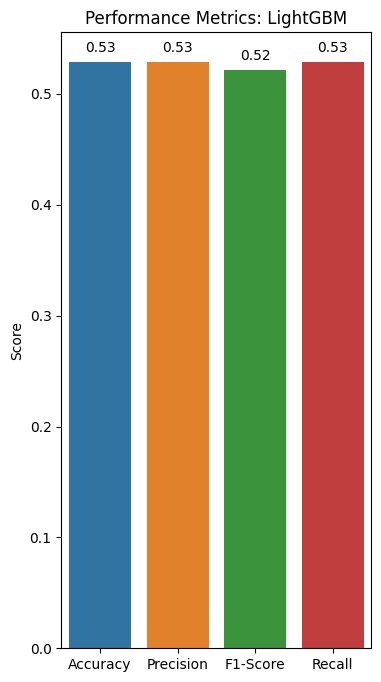

In [35]:
plt.figure(figsize=(4, 8))
ax = sns.barplot(data=metrics_df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center',  
                va = 'center',  
                xytext = (0, 10),  
                textcoords = 'offset points')
plt.title('Performance Metrics: LightGBM')
plt.ylabel('Score')
plt.savefig(f'{plots_dir}performance_LightGBM_16.pdf', bbox_inches='tight')
plt.show()

In [36]:
y_prob = best_lgb.predict_proba(X_test)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

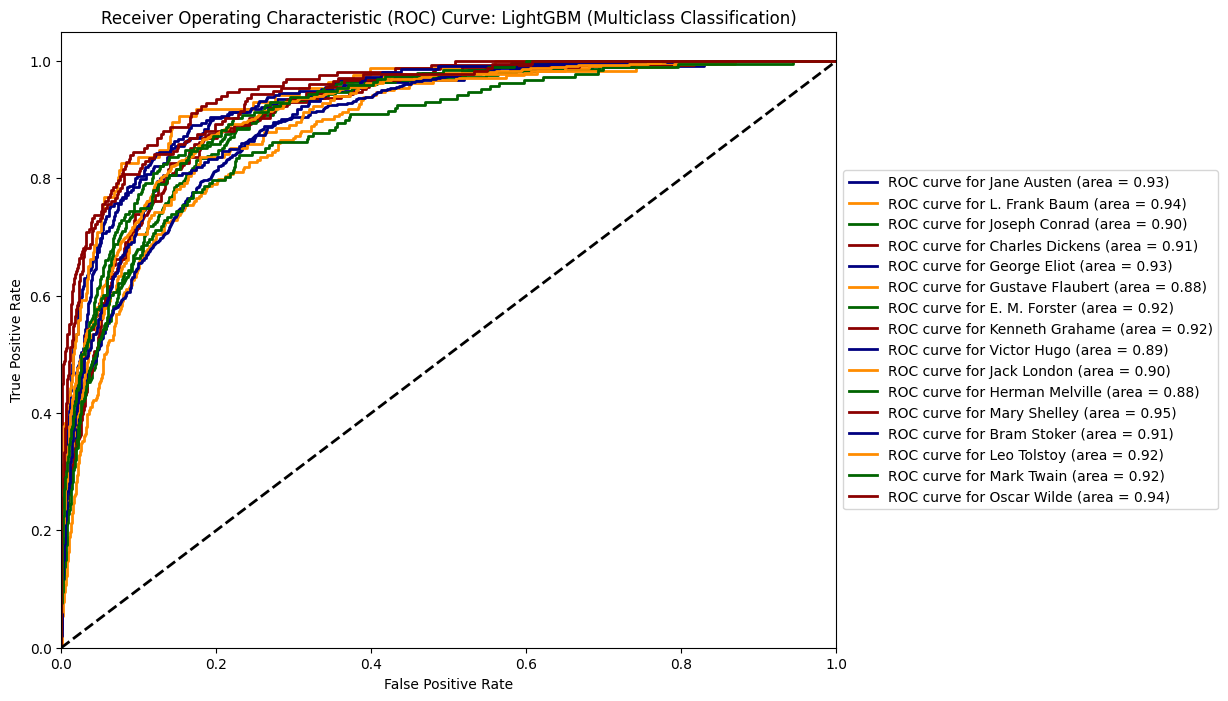

In [37]:
author_map = dict(zip(authors['AuthorCode'], authors['Author']))
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['navy', 'darkorange', 'darkgreen', 'darkred'])

plt.figure(figsize=(10, 8))

for i, color in zip(range(n_classes), colors):
    label = author_map.get(i, f'Class {i}')
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {label} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: LightGBM (Multiclass Classification)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'{plots_dir}roc_LightGBM_16.pdf', bbox_inches='tight')
plt.show()

In [38]:
best_params

{'n_estimators': 140,
 'max_depth': 7,
 'num_leaves': 36,
 'learning_rate': 0.04515518930054411,
 'min_child_samples': 24,
 'subsample': 0.6444593043305297,
 'colsample_bytree': 0.676062229348927,
 'reg_alpha': 0.0516158189332812,
 'reg_lambda': 0.3139812471363447}

In [39]:
train_loss = evals_result['training']['multi_logloss']
valid_loss = evals_result['valid_1']['multi_logloss']

In [40]:
iterations = list(range(len(train_loss)))

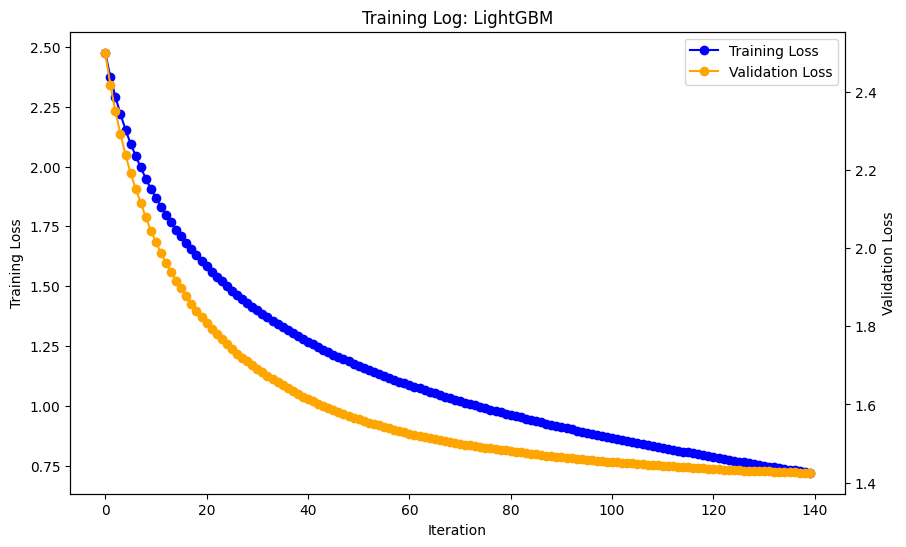

In [41]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()  
ax1.plot(iterations, train_loss, label='Training Loss', marker='o', color='blue')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Training Loss')
ax1.grid(False)


ax2 = ax1.twinx()
ax2.plot(iterations, valid_loss, label='Validation Loss', marker='o', color='orange')
ax2.set_ylabel('Validation Loss')


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()


ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.title('Training Log: LightGBM')
plt.savefig('log_light_16.pdf', bbox_inches='tight')

plt.show()

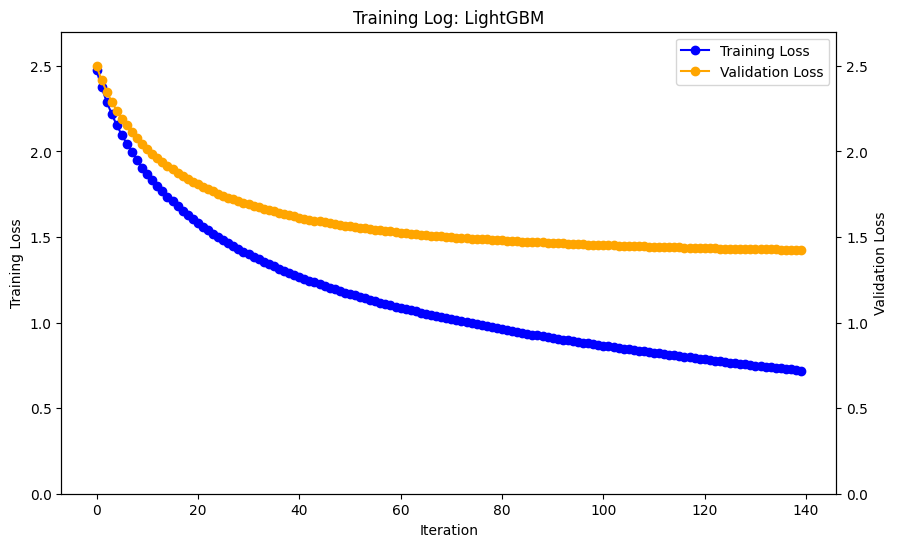

In [42]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()  
ax1.plot(iterations, train_loss, label='Training Loss', marker='o', color='blue')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Training Loss')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(iterations, valid_loss, label='Validation Loss', marker='o', color='orange')
ax2.set_ylabel('Validation Loss')

# Set the same scale for both y-axes, starting from 0
common_max = max(max(train_loss), max(valid_loss))
ax1.set_ylim(0, common_max + 0.2)
ax2.set_ylim(0, common_max+ 0.2)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.title('Training Log: LightGBM')
plt.savefig(f'{plots_dir}log_light_16.pdf', bbox_inches='tight')
plt.show()

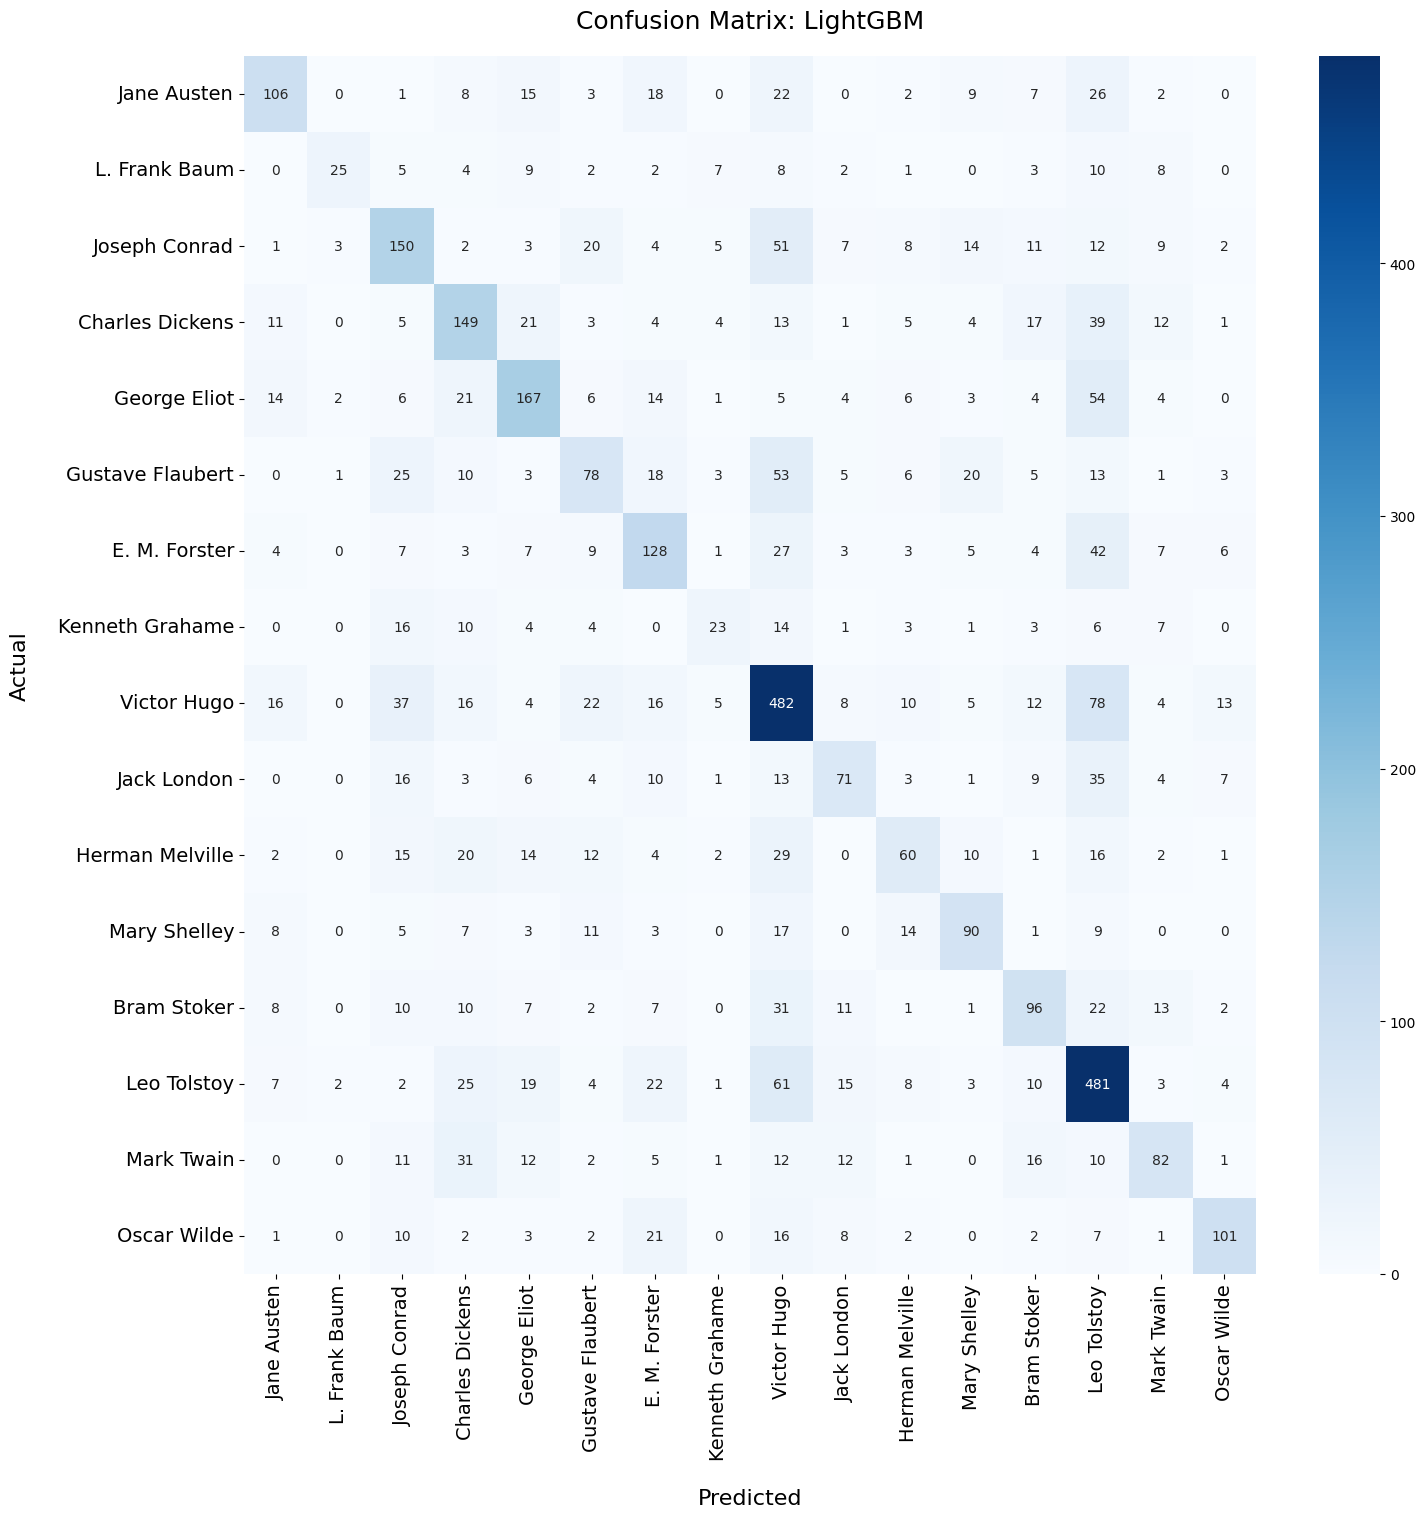

In [43]:
cm = confusion_matrix(y_test, y_pred)

# Author mappings
authors = {
    0: 'Jane Austen',
    1: 'L. Frank Baum',
    2: 'Joseph Conrad',
    3: 'Charles Dickens',
    4: 'George Eliot',
    5: 'Gustave Flaubert',
    6: 'E. M. Forster',
    7: 'Kenneth Grahame',
    8: 'Victor Hugo',
    9: 'Jack London',
    10: 'Herman Melville',
    11: 'Mary Shelley',
    12: 'Bram Stoker',
    13: 'Leo Tolstoy',
    14: 'Mark Twain',
    15: 'Oscar Wilde'
}

# Extract author names in the order of their codes
author_names = [authors.get(i, f'Label: {i}') for i in range(len(authors))]

plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=author_names, yticklabels=author_names)

plt.xlabel('Predicted', labelpad=20, fontsize=16)
plt.ylabel('Actual', labelpad=20, fontsize=16)
plt.title('Confusion Matrix: LightGBM', pad=20, fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.savefig(f'{plots_dir}cm_16_all2.pdf', bbox_inches='tight')
plt.show()

In [44]:
len(X_val)

4325